<a href="https://colab.research.google.com/github/jakemacbeth/Timberwolves-MidSeason_Review/blob/main/reports/Randle_Reid_Impact_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# imports

import sys
from pathlib import Path
import pandas as pd
from sqlalchemy import text
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence


In [28]:
# load data

base = "https://raw.githubusercontent.com/jakemacbeth/Timberwolves-MidSeason_Review/main/data/"

lineup_stats = pd.read_csv(base + "lineup_gamestats.csv")
team_lineup = pd.read_csv(base + "teams_lineup_data.csv")
team_nolineup = pd.read_csv(base + "teams_nolineup_data.csv")
teams_ratings = pd.read_csv(base + "team_ratings.csv")


In [ ]:
total_stints = 196
randle_stints = (lineup_stats['group_name'].str.contains('Randle').astype(bool)).sum()
reid_stints = (lineup_stats['group_name'].str.contains('Reid').astype(bool)).sum()
randle_reid_stints = ((lineup_stats['group_name'].str.contains('Randle').astype(bool)) &
                      (lineup_stats['group_name'].str.contains('Reid').astype(bool))).sum()
print("Total: ", total_stints)
print("Randle: ", randle_stints)
print("Reid: ", reid_stints)
print("Both: ", randle_reid_stints)

Total:  196
Randle:  123
Reid:  124
Both:  71


In [ ]:
has_randle = lineup_stats['group_name'].str.contains('Randle')
has_reid   = lineup_stats['group_name'].str.contains('Reid')
has_both   = has_randle & has_reid

total_games = 13
randle_games = lineup_stats.loc[has_randle, 'game_id'].nunique()
reid_games = lineup_stats.loc[has_reid, 'game_id'].nunique()
both_games = lineup_stats.loc[has_both, 'game_id'].nunique()

print('Total games with lineup data:' , total_games)
print('Randle games:', randle_games)
print('Reid games:', reid_games)
print('Both games:', both_games)

Total games with lineup data: 13
Randle games: 13
Reid games: 13
Both games: 13


Both players appeared together and individually in every game but we only have
    13/56 games  available to us so I will be
    checking for differences in opponent strength of the teams they did play where there is lineup specific data available vs the teams
    there is not because this is one of the main factors in player perfromance and I will be controlling for this factor during regression.

In [29]:
print('teams with lineup data available')
print(team_lineup)
print('teams with no lineup data available')
print(team_nolineup)

teams with lineup data available
    team_name     team_id
0     Celtics  1610612738
1     Rockets  1610612745
2     Hornets  1610612766
3       Hawks  1610612737
4     Wizards  1610612764
5    Clippers  1610612746
6    Warriors  1610612744
7   Cavaliers  1610612739
8        Heat  1610612748
9       Kings  1610612758
10     Pacers  1610612754
11  Mavericks  1610612742
teams with no lineup data available
        team_name     team_id
0          Lakers  1610612747
1            Nets  1610612751
2    Timberwolves  1610612750
3            Suns  1610612756
4           Bucks  1610612749
5         Thunder  1610612760
6       Grizzlies  1610612763
7   Trail Blazers  1610612757
8         Raptors  1610612761
9         Pistons  1610612765
10        Nuggets  1610612743
11          Spurs  1610612759
12         Knicks  1610612752
13           Jazz  1610612762
14          76ers  1610612755
15       Pelicans  1610612740
16          Magic  1610612753
17          Bulls  1610612741


In [30]:
lineup_ratings = teams_ratings[teams_ratings['team_id'].isin(team_lineup['team_id'])]
print('Lineup data available:')
print(lineup_ratings)

nolineup_ratings = teams_ratings[teams_ratings['team_id'].isin(team_nolineup['team_id'])]
print('No lineup data available:' )
print(nolineup_ratings)

Lineup data available:
       team_id  net_rating  off_rating  def_rating
1   1610612744         2.0       114.4       112.4
4   1610612737        -1.2       113.6       114.8
7   1610612758       -10.2       109.7       119.9
9   1610612739         4.1       117.5       113.3
10  1610612738         7.5       120.2       112.7
14  1610612748         2.1       113.9       111.8
16  1610612746        -0.3       115.5       115.8
19  1610612766         1.6       116.4       114.8
20  1610612764       -11.1       109.4       120.5
22  1610612742        -3.4       110.3       113.6
24  1610612754        -7.4       108.9       116.2
27  1610612745         5.0       117.1       112.0
No lineup data available:
       team_id  net_rating  off_rating  def_rating
0   1610612752         6.3       118.8       112.5
2   1610612762        -7.5       113.7       121.4
3   1610612747        -0.4       116.3       116.7
5   1610612743         4.0       120.9       116.9
6   1610612750         4.0       

In [31]:
stats_to_test = ["net_rating", "off_rating", "def_rating"]

def cohens_d(a, b):
    pooled_std = np.sqrt((a.std()**2 + b.std()**2) / 2)
    return (a.mean() - b.mean()) / pooled_std if pooled_std > 0 else 0.0

print(f"{'Statistic':<15} {'Played Mean':>12} {'Not Played Mean':>16} {'U stat':>8} {'p-value':>9} {'Cohen d':>9}")
print("-" * 75)

for col in stats_to_test:
    a = lineup_ratings[col]
    b = nolineup_ratings[col]
    u, p = stats.mannwhitneyu(a, b, alternative="two-sided")
    d = cohens_d(a, b)
    print(f"{col:<15} {a.mean():>12.2f} {b.mean():>16.2f} {u:>8.1f} {p:>9.4f} {d:>9.3f}")

Statistic        Played Mean  Not Played Mean   U stat   p-value   Cohen d
---------------------------------------------------------------------------
net_rating             -0.94             0.61     99.5    0.7348    -0.274
off_rating            113.91           115.01     95.5    0.6114    -0.347
def_rating            114.82           114.44    105.0    0.9157     0.114


Despite unbalanced groups there seems to be no evidence of difference in team strength between the games we have lineup data available and the games we do not.

In [36]:
lineup_stats['randle'] = lineup_stats['group_name'].str.contains('Randle').astype(int)
lineup_stats['reid']   = lineup_stats['group_name'].str.contains('Reid').astype(int)
lineup_stats['randle_reid'] = lineup_stats['randle'] * lineup_stats['reid']

model = smf.wls(
    "plus_minus ~ randle + reid + randle_reid + C(opponent_team_id)",
    data=lineup_stats,
    weights=lineup_stats["min"]
)

res = model.fit(cov_type="HC3")
print(res.summary())

                            WLS Regression Results                            
Dep. Variable:             plus_minus   R-squared:                       0.144
Model:                            WLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1.018
Date:                Sun, 01 Mar 2026   Prob (F-statistic):              0.438
Time:                        00:33:15   Log-Likelihood:                -682.75
No. Observations:                 196   AIC:                             1395.
Df Residuals:                     181   BIC:                             1445.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

 `Checking assumptions `

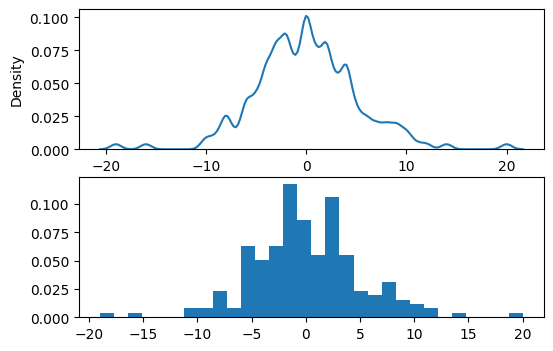

In [38]:
fig, axes = plt.subplots(2, 1, figsize = (6,4))
sns.kdeplot(lineup_stats['plus_minus'], bw_adjust=.3, ax=axes[0])
axes[1].hist(lineup_stats['plus_minus'], bins=30, density=True)
plt.show()

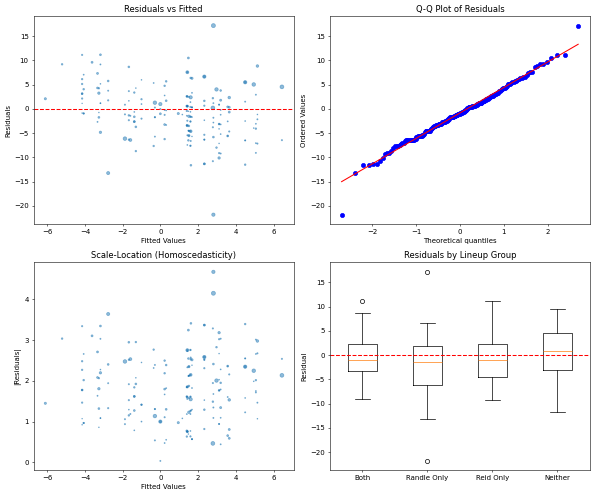

Breusch-Pagan: stat=16.740, p=0.2703
Homoscedastic — SEs valid either way


In [46]:
fitted = res.fittedvalues
resid  = res.resid
weights = lineup_stats["min"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=50)

# 1. Residuals vs Fitted — checks linearity and homoscedasticity
axes[0,0].scatter(fitted, resid, alpha=0.5, s=weights*2)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")

# 2. Q-Q Plot — checks normality of residuals (expect deviation given JB result)
stats.probplot(resid, dist="norm", plot=axes[0,1])
axes[0,1].set_title("Q-Q Plot of Residuals")

# 3. Scale-Location — checks homoscedasticity
axes[1,0].scatter(fitted, np.sqrt(np.abs(resid)), alpha=0.5, s=weights*2)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("|Residuals|")
axes[1,0].set_title("Scale-Location (Homoscedasticity)")

# 4. Residuals by lineup group — key diagnostic for your hypothesis
lineup_stats["resid"] = resid.values
groups = {
    "Both":        lineup_stats["randle_reid"] == 1,
    "Randle Only": (lineup_stats["randle"] == 1) & (lineup_stats["randle_reid"] == 0),
    "Reid Only":   (lineup_stats["reid"]   == 1) & (lineup_stats["randle_reid"] == 0),
    "Neither":     (lineup_stats["randle"] == 0) & (lineup_stats["reid"] == 0),
}
axes[1,1].boxplot(
    [lineup_stats.loc[mask, "resid"].values for mask in groups.values()],
    tick_labels=groups.keys()
)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title("Residuals by Lineup Group")
axes[1,1].set_ylabel("Residual")

plt.tight_layout()
plt.show()

# Breusch-Pagan formal heteroscedasticity test
bp_stat, bp_p, _, _ = het_breuschpagan(resid, res.model.exog)
print(f"Breusch-Pagan: stat={bp_stat:.3f}, p={bp_p:.4f}")
print("HC3/cluster SEs are warranted" if bp_p < 0.05 else "Homoscedastic — SEs valid either way")

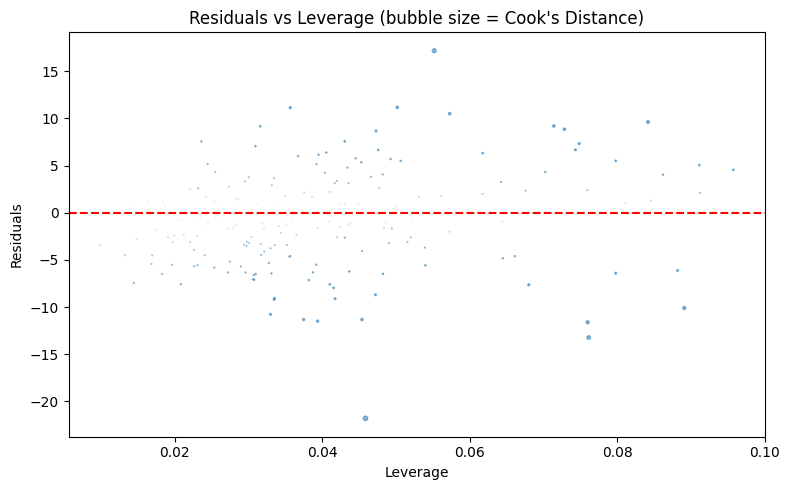

High influence stints (Cook's D > 0.020): 0
Max Cook's Distance: 0.0105


In [48]:
influence = OLSInfluence(res)
leverage  = influence.hat_matrix_diag
cooks_d   = influence.cooks_distance[0]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(leverage, res.resid, s=cooks_d * 1000, alpha=0.5)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("Leverage")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs Leverage (bubble size = Cook's Distance)")

# Mark high-influence points (Cook's D > 4/n threshold)
threshold = 4 / len(res.resid)
high_influence = np.where(cooks_d > threshold)[0]
for i in high_influence:
    ax.annotate(f"stint {i}", (leverage[i], res.resid.iloc[i]), fontsize=7)

plt.tight_layout()
plt.show()

print(f"High influence stints (Cook's D > {threshold:.3f}): {len(high_influence)}")
print(f"Max Cook's Distance: {cooks_d.max():.4f}")

Assumptions met.

Since only 13 games are available I could not cluster on game id to account for within game correlation and instead opted for HC3. With that being said there is no evidence that Randle and Reid induvidually or when playing together significantly impact net points. To ensure these players do not have an impact on team strength I will seperate net points into points scored and points allowed to see if they impact a specific side of the game.

In [51]:
lineup_stats['pts_per_min'] = lineup_stats['pts'] / lineup_stats['min']
pts_model = smf.wls('pts_per_min ~ reid + randle + randle_reid + C(opponent_team_id)', data =  lineup_stats, weights =  lineup_stats['min'])
pts_res = pts_model.fit(cov_type="HC3")
print(pts_res.summary())

                            WLS Regression Results                            
Dep. Variable:            pts_per_min   R-squared:                       0.098
Model:                            WLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.563
Date:                Sun, 01 Mar 2026   Prob (F-statistic):             0.0934
Time:                        00:52:54   Log-Likelihood:                -313.49
No. Observations:                 196   AIC:                             657.0
Df Residuals:                     181   BIC:                             706.2
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Checking assumptions.

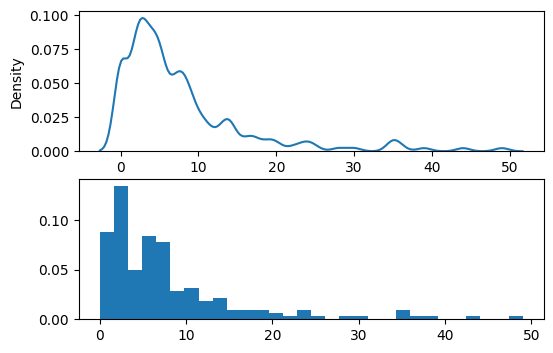

In [53]:
fig, axes = plt.subplots(2, 1, figsize = (6,4))
sns.kdeplot(lineup_stats['pts'], bw_adjust=.3, ax=axes[0])
axes[1].hist(lineup_stats['pts'], bins=30, density=True)
plt.show()

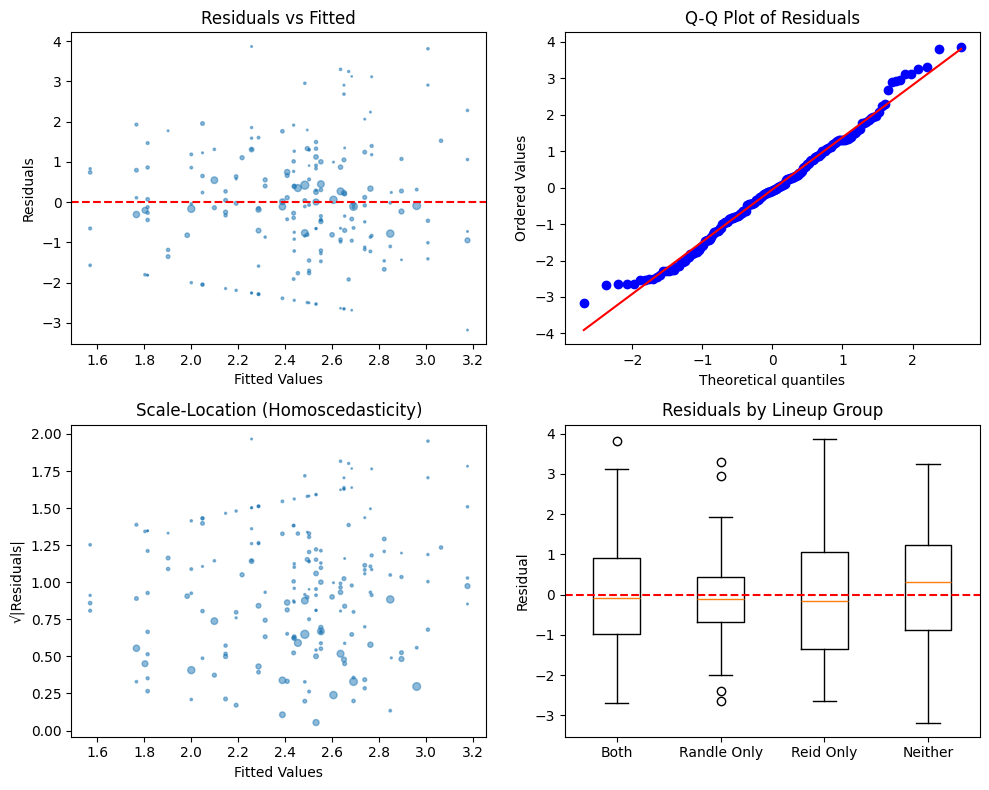

Breusch-Pagan: stat=24.290, p=0.0423
HC3/cluster SEs are warranted


In [59]:
pts_fitted = pts_res.fittedvalues
pts_resid  = pts_res.resid
weights = lineup_stats["min"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1. Residuals vs Fitted — checks linearity and homoscedasticity
axes[0,0].scatter(pts_fitted, pts_resid, alpha=0.5, s=weights*2)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")

# 2. Q-Q Plot — checks normality of residuals (expect deviation given JB result)
stats.probplot(pts_resid, dist="norm", plot=axes[0,1])
axes[0,1].set_title("Q-Q Plot of Residuals")

# 3. Scale-Location — checks homoscedasticity
axes[1,0].scatter(pts_fitted, np.sqrt(np.abs(pts_resid)), alpha=0.5, s=weights*2)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("√|Residuals|")
axes[1,0].set_title("Scale-Location (Homoscedasticity)")

# 4. Residuals by lineup group — key diagnostic for your hypothesis
lineup_stats["pts_resid"] = pts_resid.values
groups = {
    "Both":        lineup_stats["randle_reid"] == 1,
    "Randle Only": (lineup_stats["randle"] == 1) & (lineup_stats["randle_reid"] == 0),
    "Reid Only":   (lineup_stats["reid"]   == 1) & (lineup_stats["randle_reid"] == 0),
    "Neither":     (lineup_stats["randle"] == 0) & (lineup_stats["reid"] == 0),
}
axes[1,1].boxplot(
    [lineup_stats.loc[mask, "pts_resid"].values for mask in groups.values()],
    tick_labels=groups.keys()
)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title("Residuals by Lineup Group")
axes[1,1].set_ylabel("Residual")

plt.tight_layout()
plt.show()

# Breusch-Pagan formal heteroscedasticity test
bp_stat, bp_p, _, _ = het_breuschpagan(pts_resid, pts_res.model.exog)
print(f"Breusch-Pagan: stat={bp_stat:.3f}, p={bp_p:.4f}")
print("HC3/cluster SEs are warranted" if bp_p < 0.05 else "Homoscedastic — SEs valid either way")

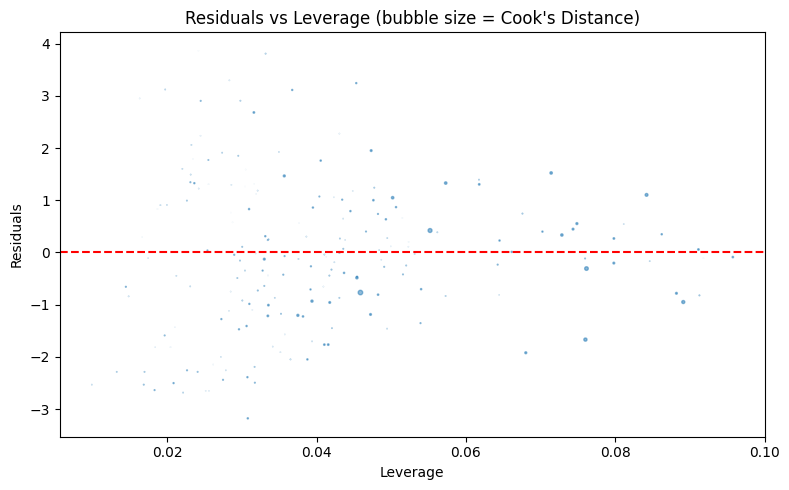

High influence stints (Cook's D > 0.020): 0
Max Cook's Distance: 0.0105


In [55]:
pts_influence = OLSInfluence(pts_res)
pts_leverage  = influence.hat_matrix_diag
pts_cooks_d   = influence.cooks_distance[0]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(pts_leverage, pts_res.resid, s=pts_cooks_d * 1000, alpha=0.5)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("Leverage")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs Leverage (bubble size = Cook's Distance)")

# Mark high-influence points (Cook's D > 4/n threshold)
pts_threshold = 4 / len(pts_res.resid)
pts_high_influence = np.where(pts_cooks_d > pts_threshold)[0]
for i in pts_high_influence:
    ax.annotate(f"stint {i}", (pts_leverage[i], pts_res.resid.iloc[i]), fontsize=7)

plt.tight_layout()
plt.show()

print(f"High influence stints (Cook's D > {pts_threshold:.3f}): {len(pts_high_influence)}")
print(f"Max Cook's Distance: {pts_cooks_d.max():.4f}")

Points scored is consistent with consistent with net points. These two players do not seem to have a decisive impact on points scored.

In [58]:
lineup_stats['ptsa'] = lineup_stats['pts'] - lineup_stats['plus_minus']
lineup_stats['ptsa_per_min'] = lineup_stats['ptsa'] / lineup_stats['min']
ptsa_model = smf.wls('ptsa_per_min ~ reid + randle + randle_reid + C(opponent_team_id)', data = lineup_stats, weights= lineup_stats['min'])
ptsa_res = ptsa_model.fit(cov_type="HC3")
print(ptsa_results.summary())

                            WLS Regression Results                            
Dep. Variable:           ptsa_per_min   R-squared:                       0.075
Model:                            WLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.194
Date:                Sun, 01 Mar 2026   Prob (F-statistic):              0.283
Time:                        01:06:56   Log-Likelihood:                -316.72
No. Observations:                 196   AIC:                             663.4
Df Residuals:                     181   BIC:                             712.6
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Checking assumptions

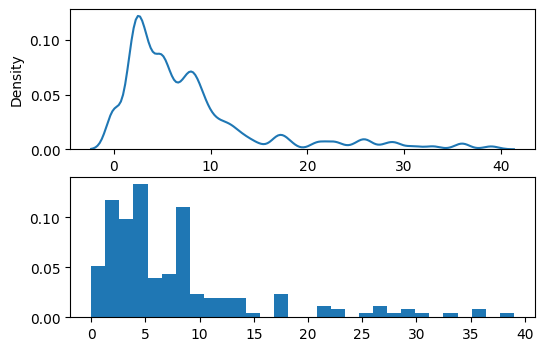

In [57]:
fig, axes = plt.subplots(2, 1, figsize = (6,4))
sns.kdeplot(lineup_stats['ptsa'], bw_adjust=.3, ax=axes[0])
axes[1].hist(lineup_stats['ptsa'], bins=30, density=True)
plt.show()

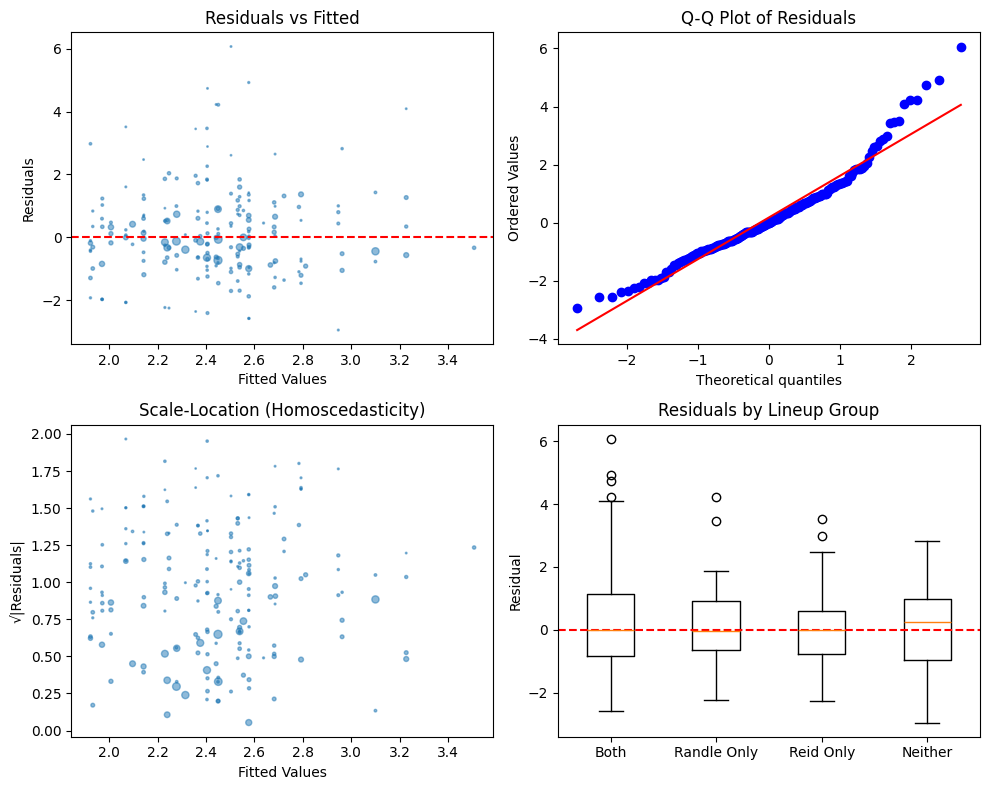

Breusch-Pagan: stat=11.420, p=0.6527
Homoscedastic — SEs valid either way


In [60]:
ptsa_fitted = ptsa_res.fittedvalues
ptsa_resid  = ptsa_res.resid

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1. Residuals vs Fitted — checks linearity and homoscedasticity
axes[0,0].scatter(ptsa_fitted, ptsa_resid, alpha=0.5, s=weights*2)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")

# 2. Q-Q Plot — checks normality of residuals (expect deviation given JB result)
stats.probplot(ptsa_resid, dist="norm", plot=axes[0,1])
axes[0,1].set_title("Q-Q Plot of Residuals")

# 3. Scale-Location — checks homoscedasticity
axes[1,0].scatter(ptsa_fitted, np.sqrt(np.abs(pts_resid)), alpha=0.5, s=weights*2)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("√|Residuals|")
axes[1,0].set_title("Scale-Location (Homoscedasticity)")

# 4. Residuals by lineup group — key diagnostic for your hypothesis
lineup_stats["pts_resid"] = ptsa_resid.values
groups = {
    "Both":        lineup_stats["randle_reid"] == 1,
    "Randle Only": (lineup_stats["randle"] == 1) & (lineup_stats["randle_reid"] == 0),
    "Reid Only":   (lineup_stats["reid"]   == 1) & (lineup_stats["randle_reid"] == 0),
    "Neither":     (lineup_stats["randle"] == 0) & (lineup_stats["reid"] == 0),
}
axes[1,1].boxplot(
    [lineup_stats.loc[mask, "pts_resid"].values for mask in groups.values()],
    tick_labels=groups.keys()
)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title("Residuals by Lineup Group")
axes[1,1].set_ylabel("Residual")

plt.tight_layout()
plt.show()

# Breusch-Pagan formal heteroscedasticity test
bp_stat, bp_p, _, _ = het_breuschpagan(ptsa_resid, ptsa_res.model.exog)
print(f"Breusch-Pagan: stat={bp_stat:.3f}, p={bp_p:.4f}")
print("HC3/cluster SEs are warranted" if bp_p < 0.05 else "Homoscedastic — SEs valid either way")

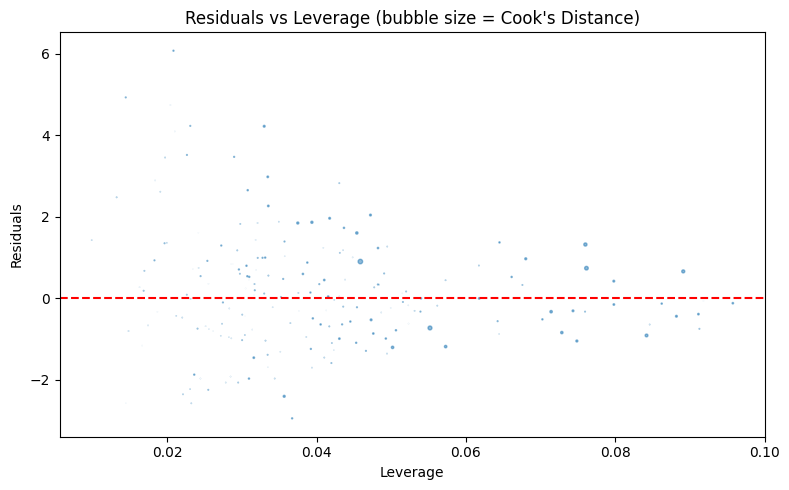

High influence stints (Cook's D > 0.020): 0
Max Cook's Distance: 0.0105


In [61]:
ptsa_influence = OLSInfluence(pts_res)
ptsa_leverage  = influence.hat_matrix_diag
ptsa_cooks_d   = influence.cooks_distance[0]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(ptsa_leverage, ptsa_res.resid, s=ptsa_cooks_d * 1000, alpha=0.5)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("Leverage")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs Leverage (bubble size = Cook's Distance)")

# Mark high-influence points (Cook's D > 4/n threshold)
ptsa_threshold = 4 / len(ptsa_res.resid)
ptsa_high_influence = np.where(ptsa_cooks_d > ptsa_threshold)[0]
for i in pts_high_influence:
    ax.annotate(f"stint {i}", (ptsa_leverage[i], ptsa_res.resid.iloc[i]), fontsize=7)

plt.tight_layout()
plt.show()

print(f"High influence stints (Cook's D > {pts_threshold:.3f}): {len(ptsa_high_influence)}")
print(f"Max Cook's Distance: {ptsa_cooks_d.max():.4f}")